# All Drought Measure Comparison - USDM Date Paired

a.stein 8.8.2022

This notebook begins to get into developing the comparison matrix between:
- USDM
- SPI
- SPEI
- EDDI
- PDSI
- Palmer Z Index
- GRACE soil moisture data

By "USDM Date Paired," I mean that while this data will be all categorized into USDM categories for similar measures, their time steps have been synced to USDM, but spatial scales have not been altered.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_2987661/1988245056.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load in data

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [3]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [4]:
intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]

In [5]:
spi = xr.open_dataset(f'{dm_path}/spi/WA/spi_usdmcat_WA.nc')

In [6]:
spei = xr.open_dataset(f'{dm_path}/spei/WA/spei_usdmcat_WA.nc')

In [7]:
eddi = xr.open_dataset(f'{dm_path}/eddi/WA/eddi_usdmcat_WA.nc')

In [8]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi_usdmcat_WA.nc')

In [9]:
grace = xr.open_dataset(f'{dm_path}/grace/WA/grace_usdmcat_WA.nc')

In [10]:
palmer_z = xr.open_dataset(f'{dm_path}/palmer_z_index/WA/palmer_z_index_usdmcat_WA.nc')

## State CAF Stacked Timeseries

In [11]:
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

### Generate or load in data if already generated

In [12]:
usdm_caf_path = f'{dm_path}/usdm/USDM_WA_caf.nc'

if not os.path.exists(usdm_caf_path):
    usdm_caf = wrangle.compile_cat_area_fracs(usdm['USDM'].rename({'date':'index'}), var_prefix="USDM")
    usdm_caf = usdm_caf.rename({'index':'date'})
    usdm_caf.to_netcdf(usdm_caf_path)
else:
    usdm_caf = xr.open_dataset(usdm_caf_path)

In [13]:
spi_caf_path = f'{dm_path}/spi/WA/spi_WA_caf.nc'

if not os.path.exists(spi_caf_path):
    spi_caf = []
    for interval in tqdm(intervals):
        spi_int = spi[f'spi_{interval}'].rename({'day':'index'})
        spi_caf.append(wrangle.compile_cat_area_fracs(spi_int, var_prefix=f"spi_{interval}"))
        spi_int = None
    spi_caf = xr.merge(spi_caf).rename({'index':'date'})
    spi_caf.to_netcdf(spi_caf_path)
else:
    spi_caf = xr.open_dataset(spi_caf_path)

In [14]:
spei_caf_path = f'{dm_path}/spei/WA/spei_WA_caf.nc'

if not os.path.exists(spei_caf_path):
    spei_caf = []
    for interval in tqdm(intervals):
        spei_caf.append(wrangle.compile_cat_area_fracs(spei[f'spei_{interval}'].rename({'day':'index'}), var_prefix=f"spei_{interval}"))
    spei_caf = xr.merge(spei_caf).rename({'index':'date'})
    spei_caf.to_netcdf(spei_caf_path)
else:
    spei_caf = xr.open_dataset(spei_caf_path)

In [15]:
eddi_caf_path = f'{dm_path}/eddi/WA/eddi_WA_caf.nc'

if not os.path.exists(eddi_caf_path):
    eddi_caf = []
    for interval in tqdm(intervals):
        eddi_caf.append(wrangle.compile_cat_area_fracs(eddi[f'eddi_{interval}'].rename({'day':'index'}), var_prefix=f"eddi_{interval}"))
    eddi_caf = xr.merge(eddi_caf).rename({'index':'date'})
    eddi_caf.to_netcdf(eddi_caf_path)
else:
    eddi_caf = xr.open_dataset(eddi_caf_path)

In [16]:
pdsi_caf_path = f'{dm_path}/pdsi/WA/pdsi_WA_caf.nc'

if not os.path.exists(pdsi_caf_path):
    pdsi_caf = wrangle.compile_cat_area_fracs(pdsi['pdsi'].rename({'day':'index'}), var_prefix="pdsi")
    pdsi_caf = pdsi_caf.rename({'index':'date'})
    pdsi_caf.to_netcdf(pdsi_caf_path)
else:
    pdsi_caf = xr.open_dataset(pdsi_caf_path)

In [17]:
grace_caf_path = f'{dm_path}/grace/WA/grace_WA_caf.nc'

if not os.path.exists(grace_caf_path):
    grace_caf = []
    for var in tqdm(['GRACEsfsm', 'GRACErtzsm', 'GRACEgws']):
        grace_caf.append(wrangle.compile_cat_area_fracs(grace[var].rename({'time':'index'}), var_prefix=var))
    grace_caf = xr.merge(grace_caf).rename({'index':'date'})
    grace_caf.to_netcdf(grace_caf_path)
else:
    grace_caf = xr.open_dataset(grace_caf_path)

In [18]:
palmer_z_caf_path = f'{dm_path}/palmer_z_index/WA/palmer_z_WA_caf.nc'

if not os.path.exists(palmer_z_caf_path):
    palmer_z_caf = wrangle.compile_cat_area_fracs(palmer_z['palmer_z'].rename({'day':'index'}), var_prefix="palmer_z")
    palmer_z_caf = palmer_z_caf.rename({'index':'date'})
    palmer_z_caf.to_netcdf(palmer_z_caf_path)
else:
    palmer_z_caf = xr.open_dataset(palmer_z_caf_path)

### Plot Data

In [19]:
usdm_colors=["white","yellow","navajowhite","orange","crimson","darkred"]

In [20]:
def plot_stacked_caf(caf_ds, vars, fig=None, axs=None, show_cbar=False):

    if axs is None or ((fig is None) & show_cbar):
        fig, axs = plt.subplots(len(vars), 1, figsize=(15,15), sharex=True)

    try:
        axs = axs.ravel()
    except:
        axs = [axs]

    dates = caf_ds['date'].values

    for ax, dm_var in zip(axs, vars):
        cumulative = np.zeros(len(caf_ds['date']))
        for cat, color in zip(np.flip(cats), np.flip(usdm_colors)):
            ax.fill_between(dates, cumulative, caf_ds[f'{dm_var}_{cat}'].values+cumulative, color=color)
            cumulative += caf_ds[f'{dm_var}_{cat}'].values

        ax.set_ylim(0,1)
        ax.set_xlim(dates[0], dates[-1])
        ax.set_ylabel(dm_var, fontsize=12)

        # helps point out missing data
        ax.set_facecolor('k')

        # fix the formating to only show hours
        formatter = mdates.DateFormatter('%Y')
        ax.xaxis.set_major_formatter(formatter)
        # set the frequency to not crowd the axis
        ax.set_xticks(pd.date_range(dates[0], dates[-1], freq='1Y'))

    if show_cbar:
        cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
        cmap = ndplot.usdm_cmap()
        bounds = np.linspace(-1, 5, 7)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, ticks=bounds)
        cbar.set_ticklabels(['Neutral/Wet', 'D0', 'D1', 'D2', 'D3', 'D4', ''], size=15)

        return fig, axs

    return axs

#### USDM

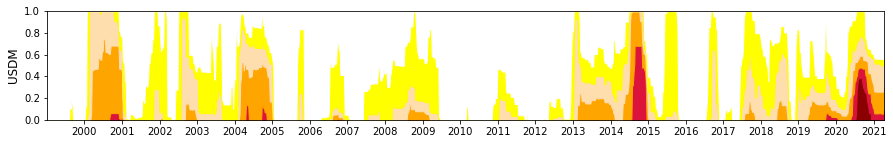

In [21]:
fig, ax = plt.subplots(figsize=(15,2))

plot_stacked_caf(
    caf_ds = usdm_caf,
    vars = ['USDM'],
    axs=ax
);

#### SPI

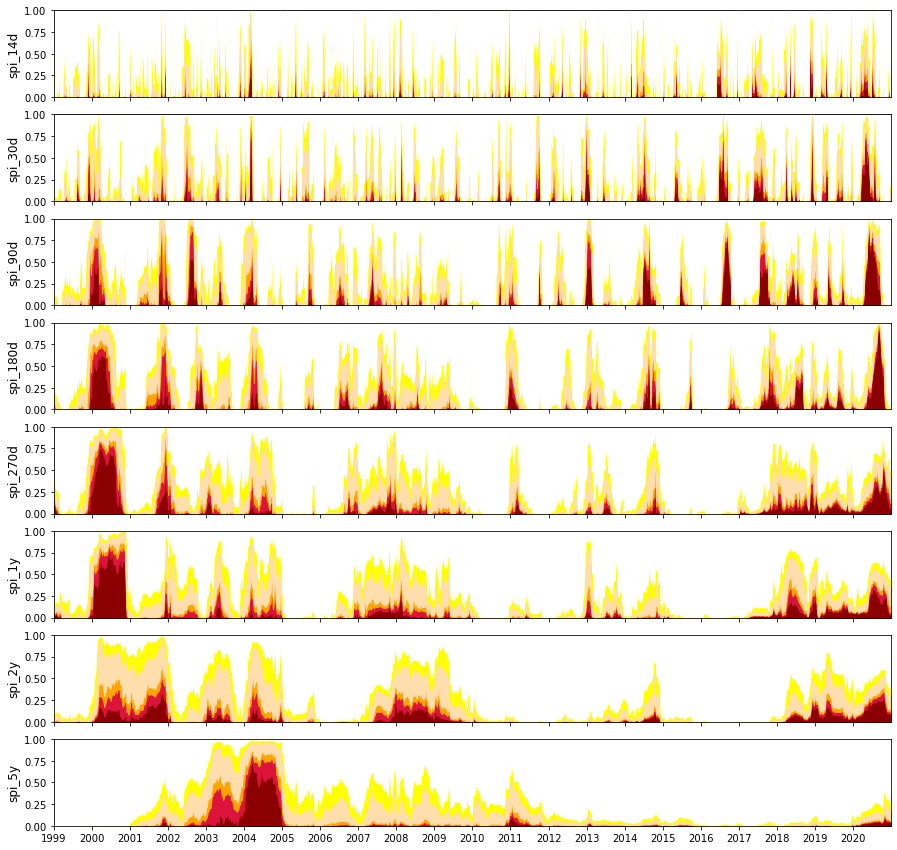

In [22]:
plot_stacked_caf(
    caf_ds = spi_caf,
    vars = [f'spi_{interval}' for interval in intervals]
);

#### SPEI

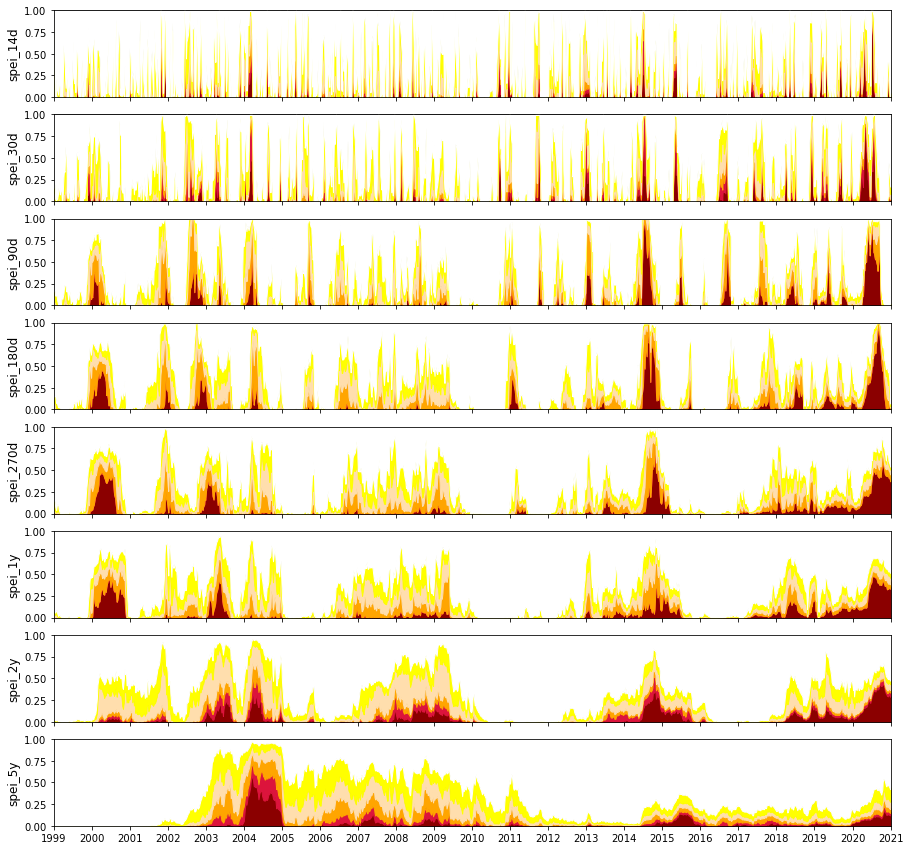

In [23]:
plot_stacked_caf(
    caf_ds = spei_caf,
    vars = [f'spei_{interval}' for interval in intervals]
);

#### EDDI

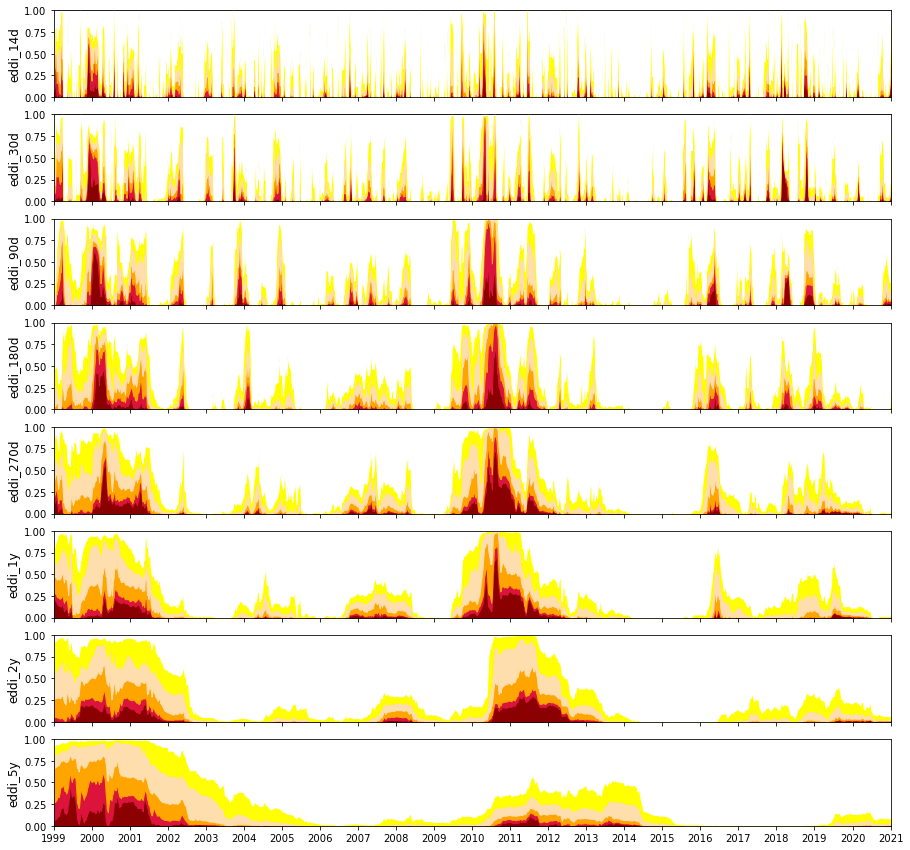

In [24]:
plot_stacked_caf(
    caf_ds = eddi_caf,
    vars = [f'eddi_{interval}' for interval in intervals]
);

#### PDSI

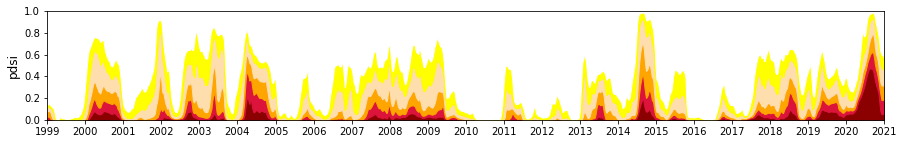

In [25]:
fig, ax = plt.subplots(figsize=(15,2))

plot_stacked_caf(
    caf_ds = pdsi_caf,
    vars = ['pdsi'],
    axs=ax
);

#### GRACE

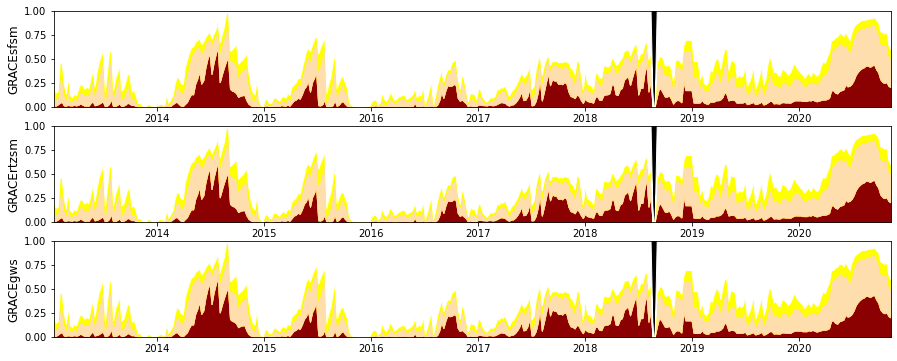

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(15,6))


plot_stacked_caf(
    caf_ds = grace_caf,
    vars = ['GRACEsfsm', 'GRACErtzsm', 'GRACEgws'],
    axs = axs
);

#### Palmer Z Index

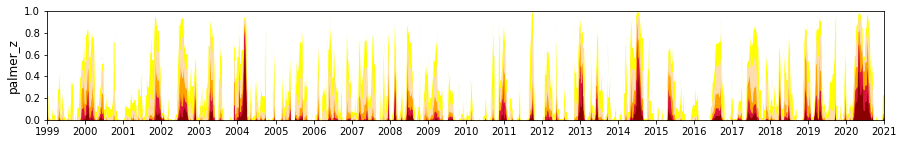

In [27]:
fig, ax = plt.subplots(figsize=(15,2))

plot_stacked_caf(
    caf_ds = palmer_z_caf,
    vars = ['palmer_z'],
    axs=ax
);

## Onset & Duration

In [28]:
def find_drought_periods(data:np.array):

    onsets = []
    ends = []

    in_drought = False
    for i, val in enumerate(data):
        if val >= 1 and not in_drought:
            in_drought = True
            onsets.append(i)
        if val < 1 and in_drought:
            ends.append(i-1)
            in_drought = False

    if len(onsets) > len(ends):
        onsets = onsets[:-1]

    return onsets, ends

In [29]:
def compile_pixel_periods(data: np.array):
    __, m, n = np.shape(data)
    number_of_droughts = np.zeros(np.shape(data)[1:])
    dt_in_drought_all = []

    t = tqdm(total=m*n)

    for i in np.arange(m):
        for j in np.arange(n):
            pixel_ts = data[:, i, j]
            onsets, ends = find_drought_periods(pixel_ts)

            number_of_droughts[i, j] = len(onsets)
            periods = np.array(ends) - np.array(onsets)
            dt_in_drought_all.append(periods)

            t.update()

    return number_of_droughts, np.hstack(dt_in_drought_all)

In [30]:
import pickle

def pickle_data(data, path):

        f = open(path, 'wb')
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        f.close()

def unpickle_data(path):

    with open(path, 'rb') as f:
        return pickle.load(f)

In [31]:
path = f'{dm_path}/usdm/USDM_WA_drought_counts.pickle'

if not os.path.exists(path):
    usdm_num_droughts, usdm_dt_drought = compile_pixel_periods(usdm['USDM'].values)
    pickle_data([usdm_num_droughts, usdm_dt_drought], path)
else:
    [usdm_num_droughts, usdm_dt_drought] = unpickle_data(path)

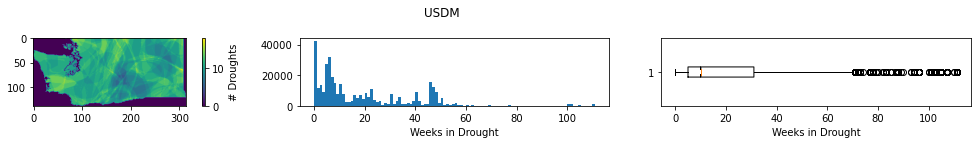

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,2))

plotted = ax[0].imshow(usdm_num_droughts)
fig.colorbar(plotted, ax=ax[0], label='# Droughts')
ax[0].set_aspect('equal')

ax[1].hist(usdm_dt_drought, bins=100)
ax[1].set_xlabel('Weeks in Drought')

ax[2].boxplot(usdm_dt_drought, notch=True, vert=False)
ax[2].set_xlabel('Weeks in Drought')


fig.suptitle('USDM')

plt.tight_layout()

In [33]:
path = f'{dm_path}/spi/WA/spi_WA_drought_counts.pickle'

if not os.path.exists(path):
    spi_num_droughts = dict()
    spi_dt_droughts = dict()

    for interval in tqdm(intervals):
        num_droughts, dt_droughts = compile_pixel_periods(spi[f'spi_{interval}'].values)
        spi_num_droughts[interval] = num_droughts
        spi_dt_droughts[interval] = dt_droughts

    pickle_data([spi_num_droughts, spi_dt_droughts], path)
else:
    [spi_num_droughts, spi_dt_droughts] = unpickle_data(path)

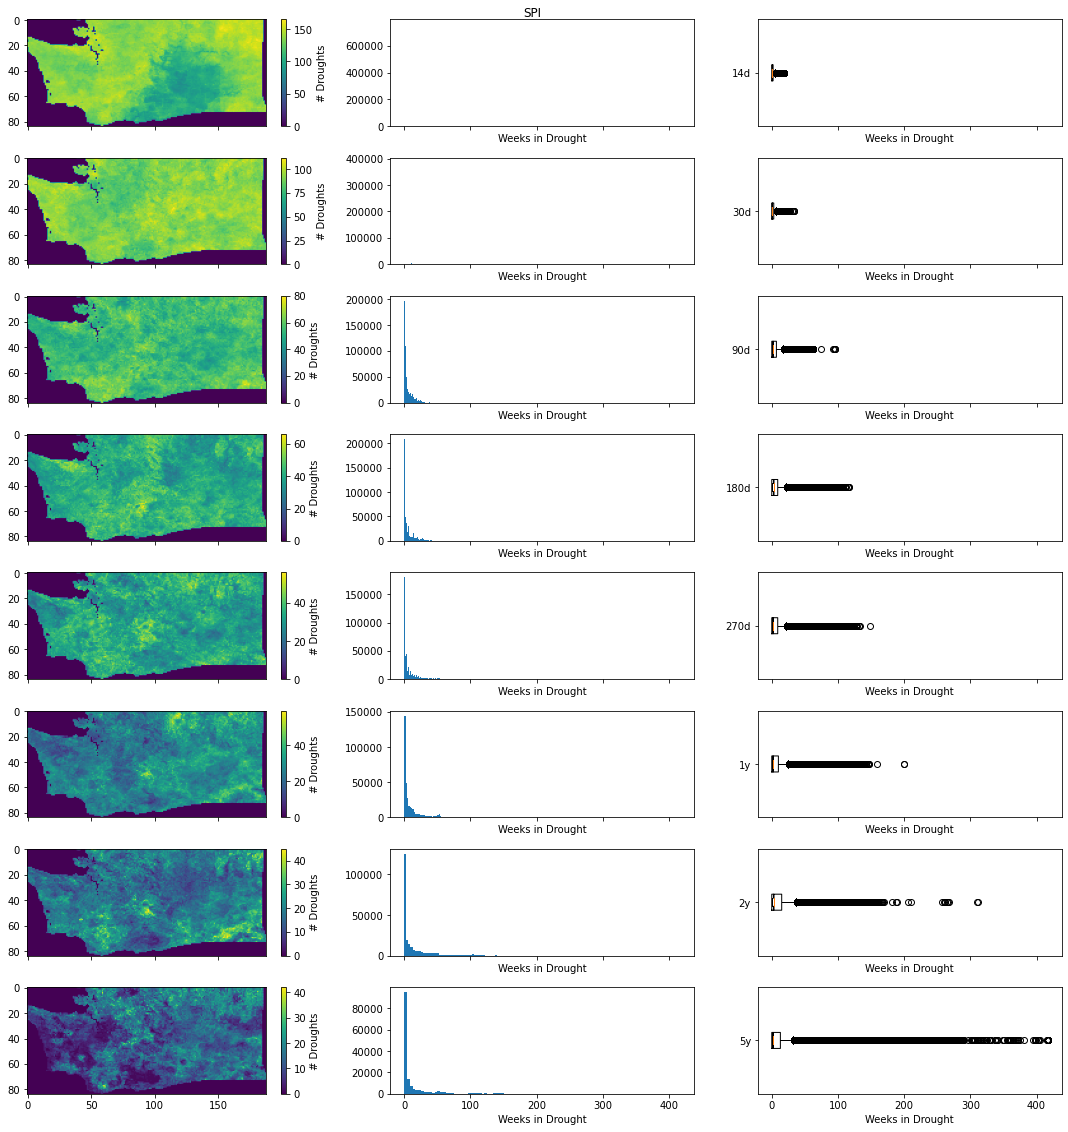

In [34]:
fig, ax = plt.subplots(len(intervals),3, figsize=(15,16), sharex='col')

for i, interval in enumerate(intervals):

    plotted = ax[i,0].imshow(spi_num_droughts[interval])
    fig.colorbar(plotted, ax=ax[i,0], label='# Droughts')
    ax[i, 0].set_aspect('equal')

    ax[i, 1].hist(spi_dt_droughts[interval], bins=100)
    ax[i, 1].set_xlabel('Weeks in Drought')

    ax[i, 2].boxplot(spi_dt_droughts[interval], notch=True, vert=False, labels=[interval])
    ax[i, 2].set_xlabel('Weeks in Drought')

fig.suptitle('SPI')

plt.tight_layout()

In [35]:
path = f'{dm_path}/spei/WA/spei_WA_drought_counts.pickle'

if not os.path.exists(path):
    spei_num_droughts = dict()
    spei_dt_droughts = dict()

    for interval in tqdm(intervals):
        num_droughts, dt_droughts = compile_pixel_periods(spei[f'spei_{interval}'].values)
        spei_num_droughts[interval] = num_droughts
        spei_dt_droughts[interval] = dt_droughts

    pickle_data([spei_num_droughts, spei_dt_droughts], path)
else:
    [spei_num_droughts, spei_dt_droughts] = unpickle_data(path)

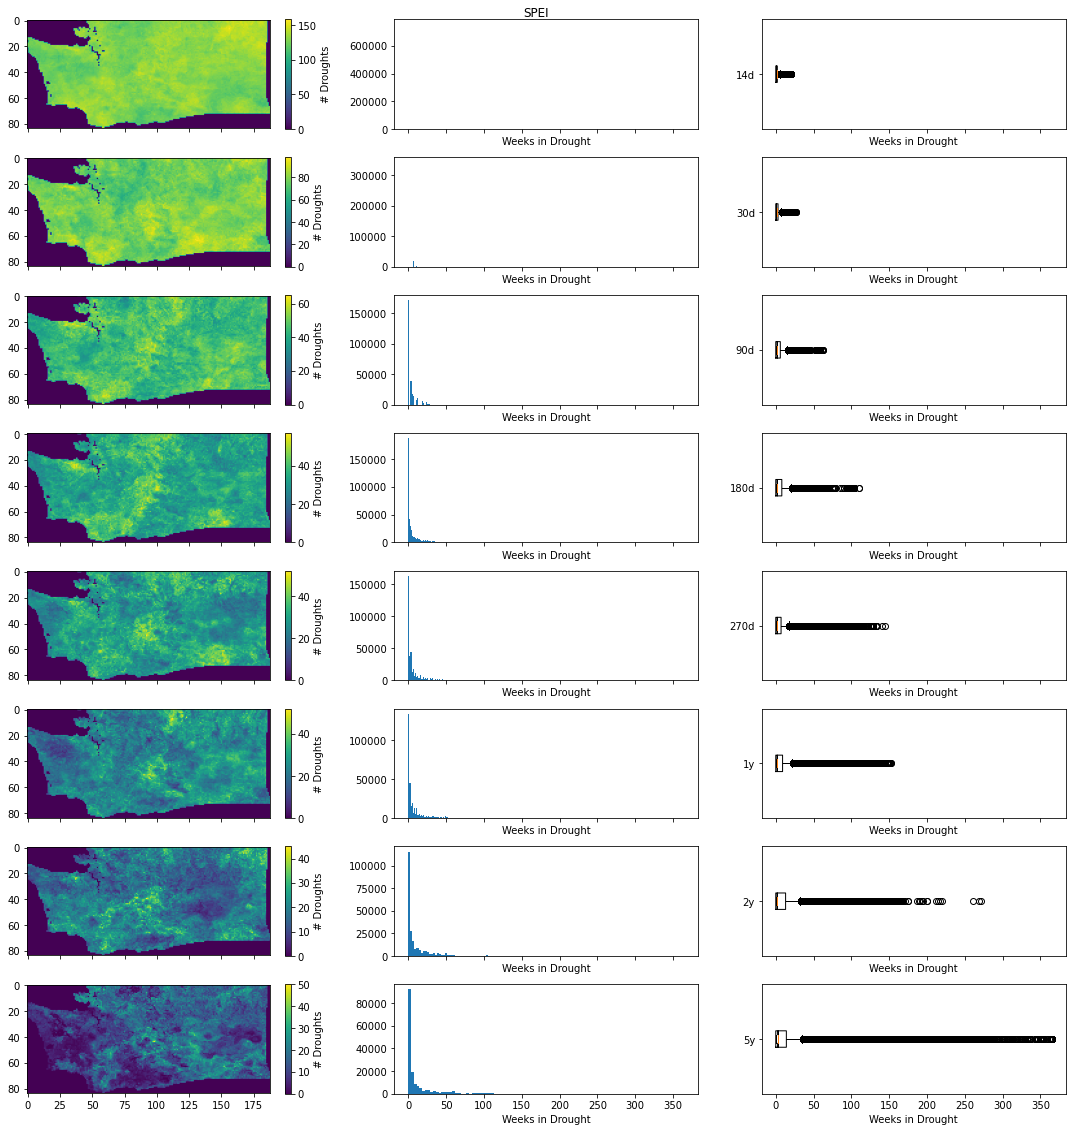

In [36]:
fig, ax = plt.subplots(len(intervals),3, figsize=(15,16), sharex='col')

for i, interval in enumerate(intervals):

    plotted = ax[i,0].imshow(spei_num_droughts[interval])
    fig.colorbar(plotted, ax=ax[i,0], label='# Droughts')
    ax[i, 0].set_aspect('equal')

    ax[i, 1].hist(spei_dt_droughts[interval], bins=100)
    ax[i, 1].set_xlabel('Weeks in Drought')

    ax[i, 2].boxplot(spei_dt_droughts[interval], notch=True, vert=False, labels=[interval])
    ax[i, 2].set_xlabel('Weeks in Drought')

fig.suptitle('SPEI')

plt.tight_layout()

In [37]:
path = f'{dm_path}/eddi/WA/eddi_WA_drought_counts.pickle'

if not os.path.exists(path):
    eddi_num_droughts = dict()
    eddi_dt_droughts = dict()

    for interval in tqdm(intervals):
        num_droughts, dt_droughts = compile_pixel_periods(eddi[f'eddi_{interval}'].values)
        eddi_num_droughts[interval] = num_droughts
        eddi_dt_droughts[interval] = dt_droughts
    pickle_data([eddi_num_droughts, eddi_dt_droughts], path)
else:
    [eddi_num_droughts, eddi_dt_droughts] = unpickle_data(path)

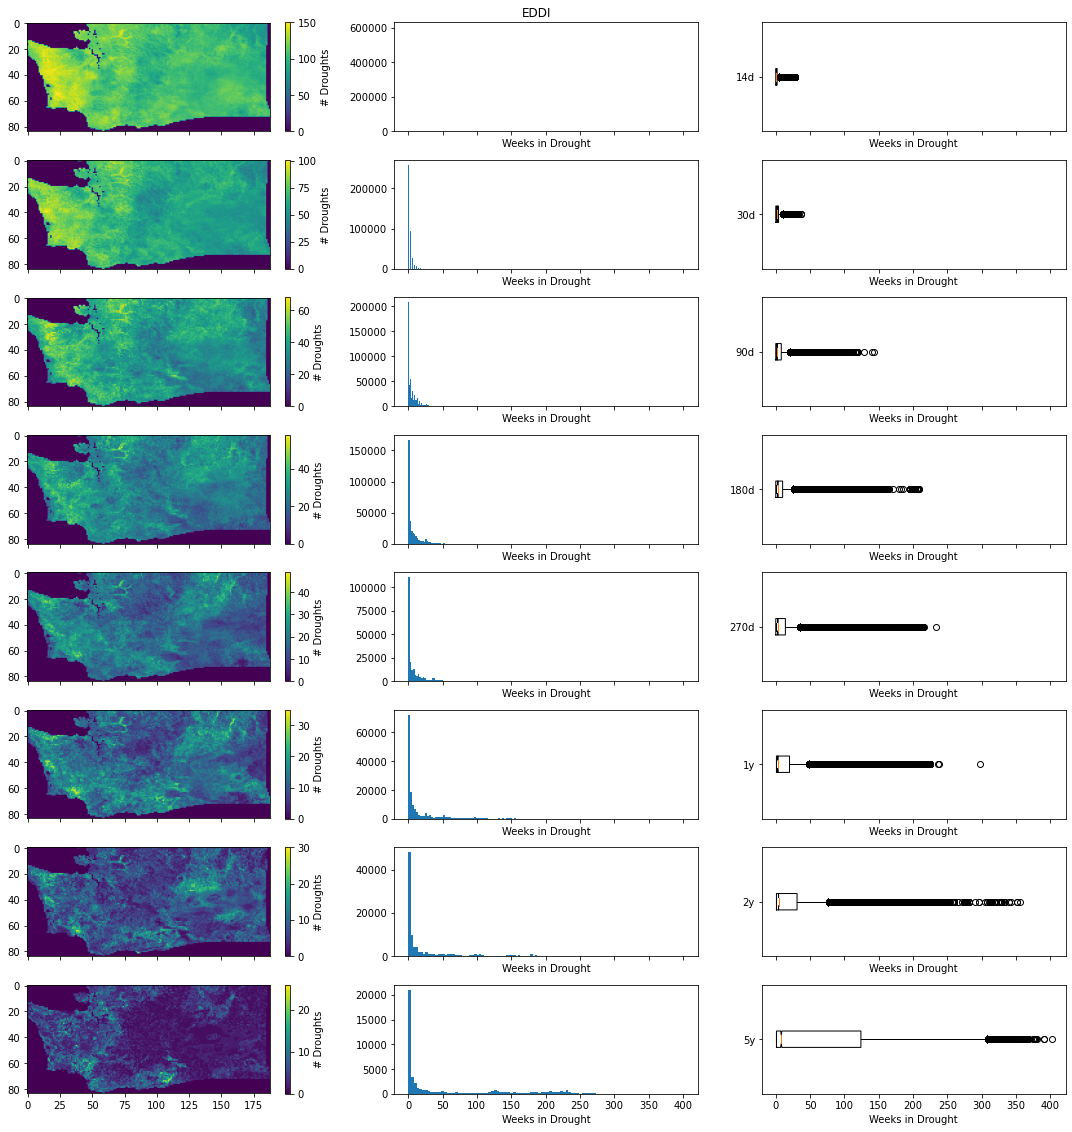

In [38]:
fig, ax = plt.subplots(len(intervals),3, figsize=(15,16), sharex='col')

for i, interval in enumerate(intervals):

    plotted = ax[i,0].imshow(eddi_num_droughts[interval])
    fig.colorbar(plotted, ax=ax[i,0], label='# Droughts')
    ax[i, 0].set_aspect('equal')

    ax[i, 1].hist(eddi_dt_droughts[interval], bins=100)
    ax[i, 1].set_xlabel('Weeks in Drought')

    ax[i, 2].boxplot(eddi_dt_droughts[interval], notch=True, vert=False, labels=[interval])
    ax[i, 2].set_xlabel('Weeks in Drought')

fig.suptitle('EDDI')

plt.tight_layout()

In [39]:
path = f'{dm_path}/pdsi/WA/pdsi_WA_drought_counts.pickle'

if not os.path.exists(path):
    pdsi_num_droughts, pdsi_dt_drought = compile_pixel_periods(pdsi['pdsi'].values)
    pickle_data([pdsi_num_droughts, pdsi_dt_drought], path)
else:
    [pdsi_num_droughts, pdsi_dt_drought] = unpickle_data(path)

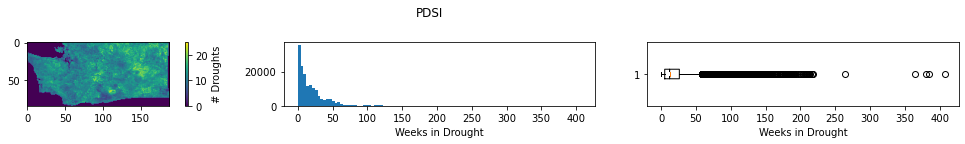

In [40]:
fig, ax = plt.subplots(1,3, figsize=(15,2))

plotted = ax[0].imshow(pdsi_num_droughts)
fig.colorbar(plotted, ax=ax[0], label='# Droughts')
ax[0].set_aspect('equal')

ax[1].hist(pdsi_dt_drought, bins=100)
ax[1].set_xlabel('Weeks in Drought')

ax[2].boxplot(pdsi_dt_drought, notch=True, vert=False)
ax[2].set_xlabel('Weeks in Drought')


fig.suptitle('PDSI')

plt.tight_layout()

In [41]:
path = f'{dm_path}/palmer_z_index/WA/palmer_z_WA_drought_counts.pickle'

if not os.path.exists(path):
    palmer_z_num_droughts, palmer_z_dt_drought = compile_pixel_periods(palmer_z['palmer_z'].values)
    pickle_data([palmer_z_num_droughts, palmer_z_dt_drought], path)
else:
    [palmer_z_num_droughts, palmer_z_dt_drought] = unpickle_data(path)

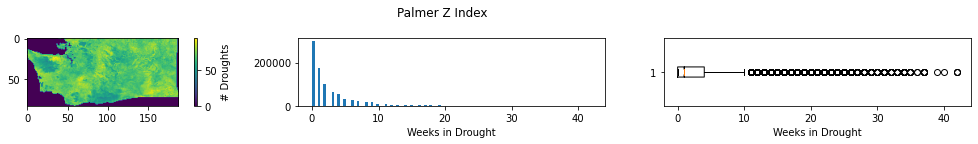

In [42]:
fig, ax = plt.subplots(1,3, figsize=(15,2))

plotted = ax[0].imshow(palmer_z_num_droughts)
fig.colorbar(plotted, ax=ax[0], label='# Droughts')
ax[0].set_aspect('equal')

ax[1].hist(palmer_z_dt_drought, bins=100)
ax[1].set_xlabel('Weeks in Drought')

ax[2].boxplot(palmer_z_dt_drought, notch=True, vert=False)
ax[2].set_xlabel('Weeks in Drought')


fig.suptitle('Palmer Z Index')

plt.tight_layout()

In [43]:
path = f'{dm_path}/grace/WA/grace_WA_drought_counts.pickle'

if not os.path.exists(path):
    grace_num_droughts = dict()
    grace_dt_droughts = dict()

    for var in tqdm(['GRACEsfsm', 'GRACErtzsm', 'GRACEgws']):
        num_droughts, dt_droughts = compile_pixel_periods(grace[var].values)
        grace_num_droughts[var] = num_droughts
        grace_dt_droughts[var] = dt_droughts
    pickle_data([grace_num_droughts, grace_dt_droughts], path)
else:
    [grace_num_droughts, grace_dt_droughts] = unpickle_data(path)

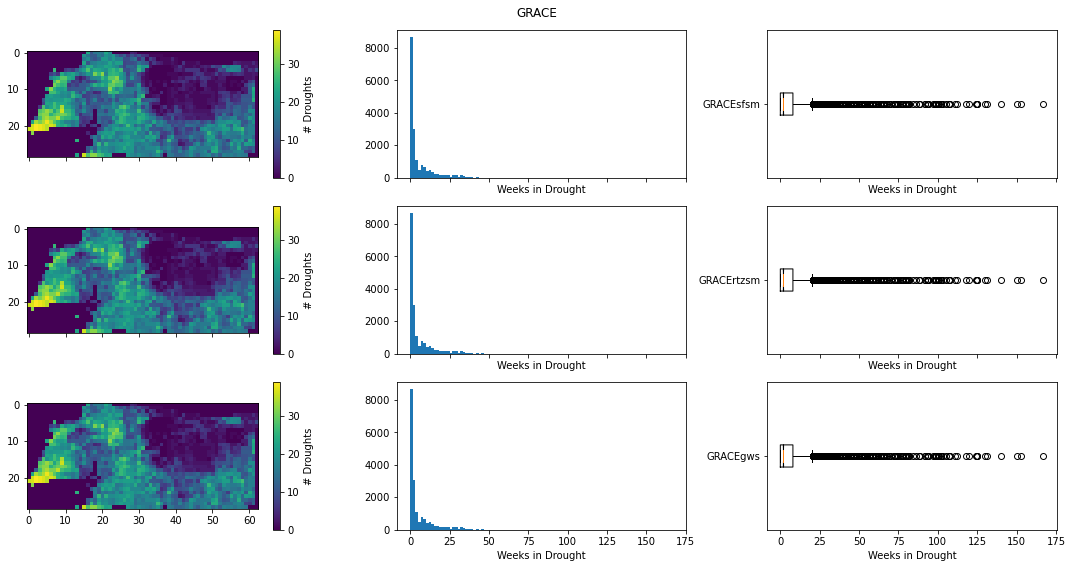

In [44]:
fig, ax = plt.subplots(3,3, figsize=(15,8), sharex='col')

for i, var in enumerate(['GRACEsfsm', 'GRACErtzsm', 'GRACEgws']):

    plotted = ax[i,0].imshow(grace_num_droughts[var])
    fig.colorbar(plotted, ax=ax[i,0], label='# Droughts')
    ax[i, 0].set_aspect('equal')

    ax[i, 1].hist(grace_dt_droughts[var], bins=100)
    ax[i, 1].set_xlabel('Weeks in Drought')

    ax[i, 2].boxplot(grace_dt_droughts[var], notch=True, vert=False, labels=[var])
    ax[i, 2].set_xlabel('Weeks in Drought')

fig.suptitle('GRACE')

plt.tight_layout()

## Drought Networks

In [55]:
import ndrought.drought_network as dnet
import networkx as nx

In [46]:
# found need to up recursion limit for atl SPI 5y
sys.setrecursionlimit(int(1e4))

In [47]:
path = f'{dm_path}/usdm/usdm_WA_net.pickle'

if not os.path.exists(path):
    usdm_net = dnet.DroughtNetwork(usdm['USDM'].values, name='USDM EPSG:4326')
else:
    usdm_net = dnet.DroughtNetwork.unpickle(path=path)

In [48]:
spi_nets = dict()

for interval in tqdm(intervals):
    path = f'{dm_path}/spi/WA/spi_{interval}_net.pickle'

    if not os.path.exists(path):
        spi_nets[interval] = dnet.DroughtNetwork(spi[f'spi_{interval}'].values, name=f'SPI {interval} EPSG: 4326')
        spi_nets[interval].pickle(path)
    else:
        spi_nets[interval] = dnet.DroughtNetwork.unpickle(path)

  0%|          | 0/8 [00:00<?, ?it/s]

In [49]:
spei_nets = dict()

for interval in tqdm(intervals):
    path = f'{dm_path}/spei/WA/spei_{interval}_net.pickle'

    if not os.path.exists(path):
        spei_nets[interval] = dnet.DroughtNetwork(spei[f'spei_{interval}'].values, name=f'SPEI {interval} EPSG: 4326')
        spei_nets[interval].pickle(path)
    else:
        spei_nets[interval] = dnet.DroughtNetwork.unpickle(path)

  0%|          | 0/8 [00:00<?, ?it/s]

In [50]:
eddi_nets = dict()

for interval in tqdm(intervals):
    path = f'{dm_path}/eddi/WA/eddi_{interval}_net.pickle'

    if not os.path.exists(path):
        eddi_nets[interval] = dnet.DroughtNetwork(eddi[f'eddi_{interval}'].values, name=f'EDDI {interval} EPSG: 4326')
        eddi_nets[interval].pickle(path)
    else:
        eddi_nets[interval] = dnet.DroughtNetwork.unpickle(path)

  0%|          | 0/8 [00:00<?, ?it/s]

In [51]:
path = f'{dm_path}/pdsi/WA/pdsi_WA_net.pickle'

if not os.path.exists(path):
    pdsi_net = dnet.DroughtNetwork(pdsi['pdsi'].values, name='USDM EPSG:4326')
else:
    pdsi_net = dnet.DroughtNetwork.unpickle(path=path)

  0%|          | 0/1149 [00:00<?, ?it/s]

In [52]:
path = f'{dm_path}/palmer_z_index/WA/palmer_z_WA_net.pickle'

if not os.path.exists(path):
    palmer_z_net = dnet.DroughtNetwork(palmer_z['palmer_z'].values, name='Palmer Z EPSG:4326')
else:
    palmer_z_net = dnet.DroughtNetwork.unpickle(path=path)

  0%|          | 0/1149 [00:00<?, ?it/s]

In [53]:
grace_nets = dict()

for var in tqdm(['GRACEsfsm', 'GRACErtzsm', 'GRACEgws']):
    path = f'{dm_path}/grace/WA/grace_{var}_net.pickle'

    if not os.path.exists(path):
        grace_nets[var] = dnet.DroughtNetwork(grace[f'{var}'].values, name=f'{var} EPSG: 4326')
        grace_nets[var].pickle(path)
    else:
        grace_nets[var] = dnet.DroughtNetwork.unpickle(path)

  0%|          | 0/3 [00:00<?, ?it/s]

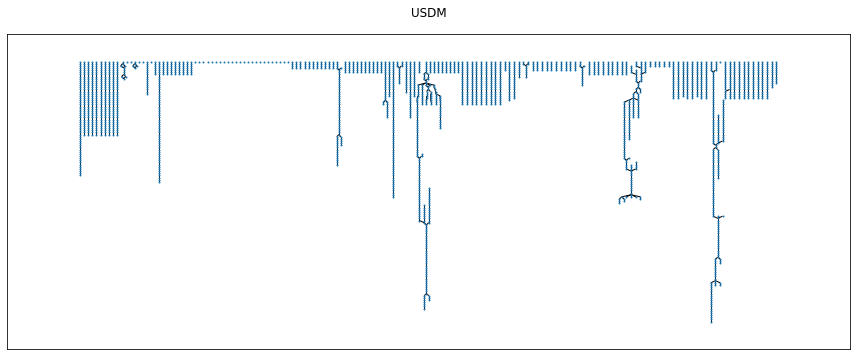

In [72]:
usdm_topog, usdm_pos = usdm_net.get_nx_network()

fig, ax = plt.subplots(figsize=(12,5))
nx.draw_networkx(usdm_topog, usdm_pos, with_labels=False, node_size=1, ax=ax)
fig.suptitle('USDM')
plt.tight_layout()

In [87]:
path = f'{dm_path}/usdm/usdm_WA_nx.pickle'

pickle_data([usdm_topog, usdm_pos], path)

In [74]:
spi_topog = dict()
spi_pos = dict()

for interval in tqdm(intervals):
    spi_topog[interval], spi_pos[interval] = spi_nets[interval].get_nx_network()

  0%|          | 0/8 [00:00<?, ?it/s]

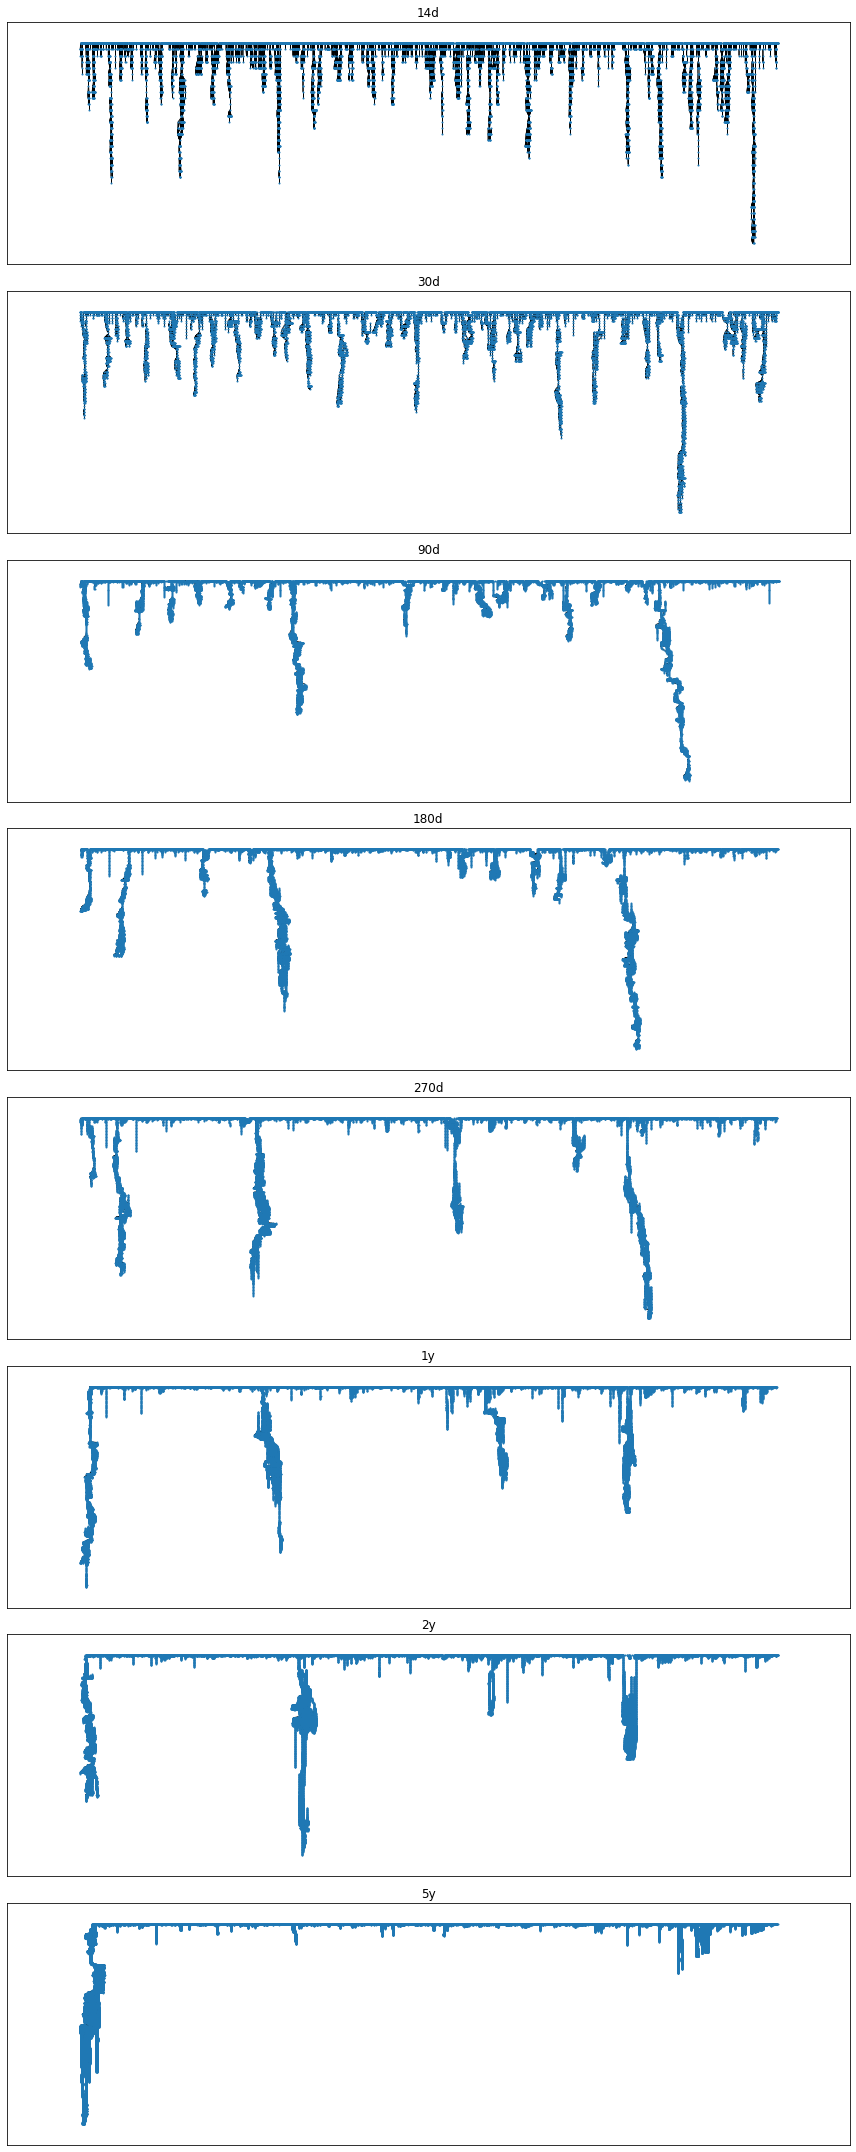

In [75]:
fig, axs = plt.subplots(len(intervals), 1, figsize=(12,30))

for ax, interval in zip(axs.ravel(), intervals):

    nx.draw_networkx(spi_topog[interval], spi_pos[interval], with_labels=False, node_size=1, ax=ax)
    ax.set_title(interval)

plt.tight_layout()

In [88]:
path = f'{dm_path}/spi/WA/spi_WA_nx.pickle'

pickle_data([spi_topog, spi_pos], path)

In [76]:
spei_topog = dict()
spei_pos = dict()

for interval in tqdm(intervals):
    spei_topog[interval], spei_pos[interval] = spei_nets[interval].get_nx_network()

  0%|          | 0/8 [00:00<?, ?it/s]

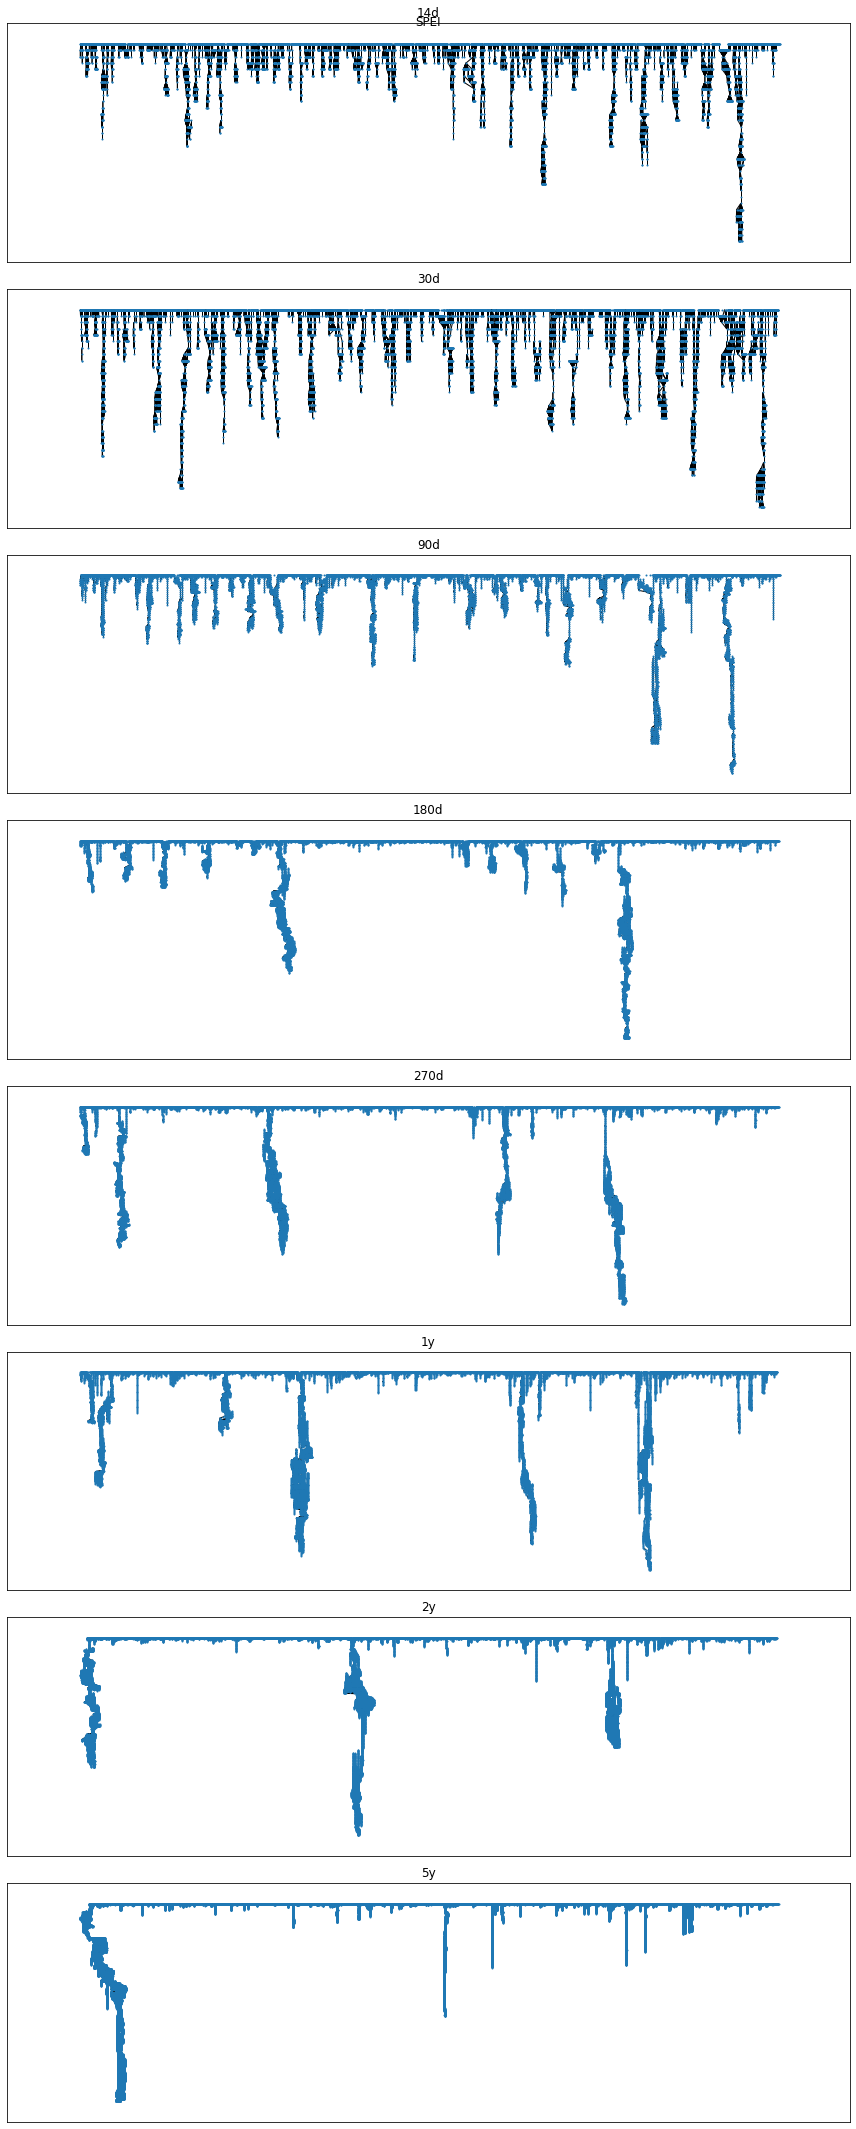

In [77]:
fig, axs = plt.subplots(len(intervals), 1, figsize=(12,30))

for ax, interval in zip(axs.ravel(), intervals):

    nx.draw_networkx(spei_topog[interval], spei_pos[interval], with_labels=False, node_size=1, ax=ax)
    ax.set_title(interval)

fig.suptitle('SPEI')

plt.tight_layout()

In [89]:
path = f'{dm_path}/spei/WA/spei_WA_nx.pickle'

pickle_data([spei_topog, spei_pos], path)

In [78]:
eddi_topog = dict()
eddi_pos = dict()

for interval in tqdm(intervals):
    eddi_topog[interval], eddi_pos[interval] = eddi_nets[interval].get_nx_network()

  0%|          | 0/8 [00:00<?, ?it/s]

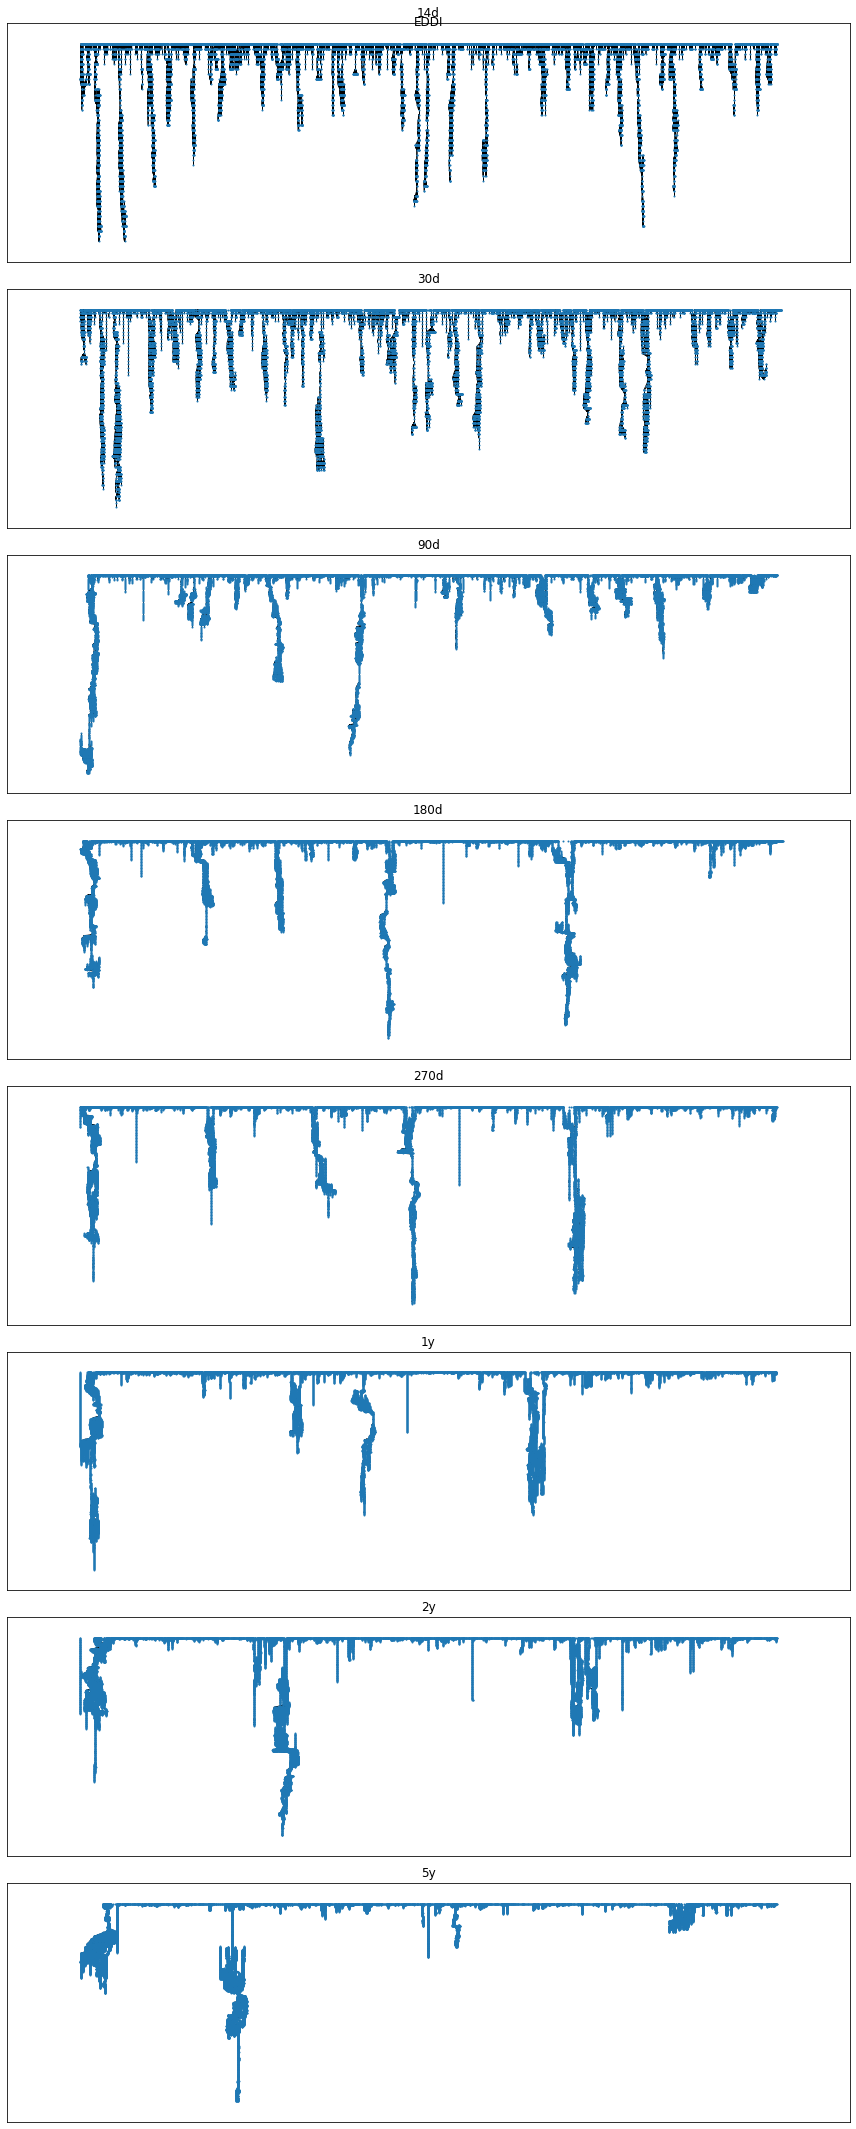

In [79]:
fig, axs = plt.subplots(len(intervals), 1, figsize=(12,30))

for ax, interval in zip(axs.ravel(), intervals):

    nx.draw_networkx(eddi_topog[interval], eddi_pos[interval], with_labels=False, node_size=1, ax=ax)
    ax.set_title(interval)

fig.suptitle('EDDI')

plt.tight_layout()

In [90]:
path = f'{dm_path}/eddi/WA/eddi_WA_nx.pickle'

pickle_data([eddi_topog, eddi_pos], path)

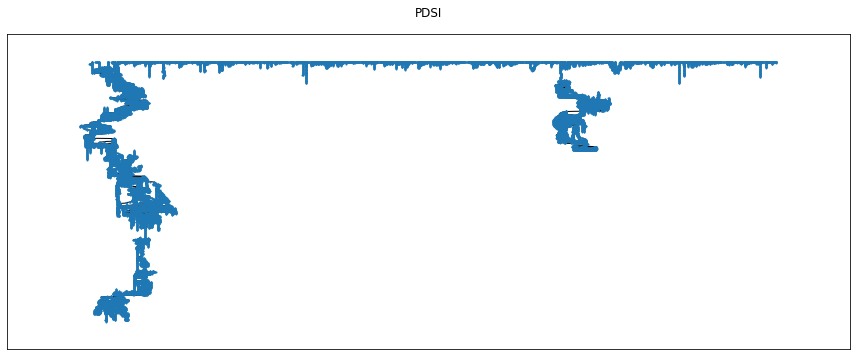

In [80]:
pdsi_topog, pdsi_pos = pdsi_net.get_nx_network()

fig, ax = plt.subplots(figsize=(12,5))
nx.draw_networkx(pdsi_topog, pdsi_pos, with_labels=False, node_size=1, ax=ax)
fig.suptitle('PDSI')
plt.tight_layout()

In [91]:
path = f'{dm_path}/pdsi/WA/pdsi_WA_nx.pickle'

pickle_data([pdsi_topog, pdsi_pos], path)

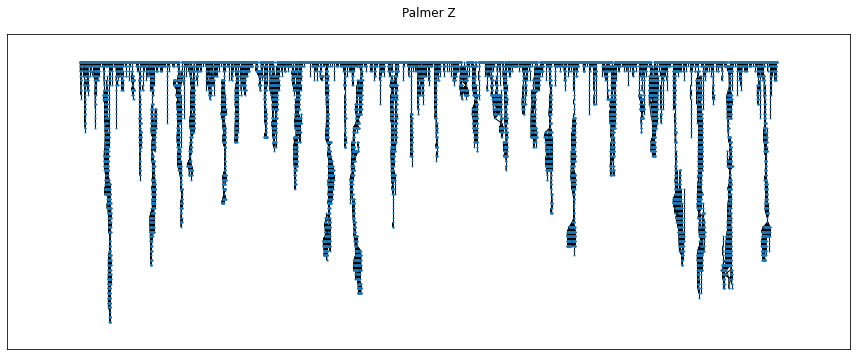

In [81]:
palmer_z_topog, palmer_z_pos = palmer_z_net.get_nx_network()

fig, ax = plt.subplots(figsize=(12,5))
nx.draw_networkx(palmer_z_topog, palmer_z_pos, with_labels=False, node_size=1, ax=ax)
fig.suptitle('Palmer Z')
plt.tight_layout()

In [93]:
path = f'{dm_path}/palmer_z_index/WA/palmer_z_WA_nx.pickle'

pickle_data([palmer_z_topog, palmer_z_pos], path)

In [84]:
grace_topog = dict()
grace_pos = dict()

for var in tqdm(['GRACEsfsm', 'GRACErtzsm', 'GRACEgws']):
    grace_topog[var], grace_pos[var] = grace_nets[var].get_nx_network()

  0%|          | 0/3 [00:00<?, ?it/s]

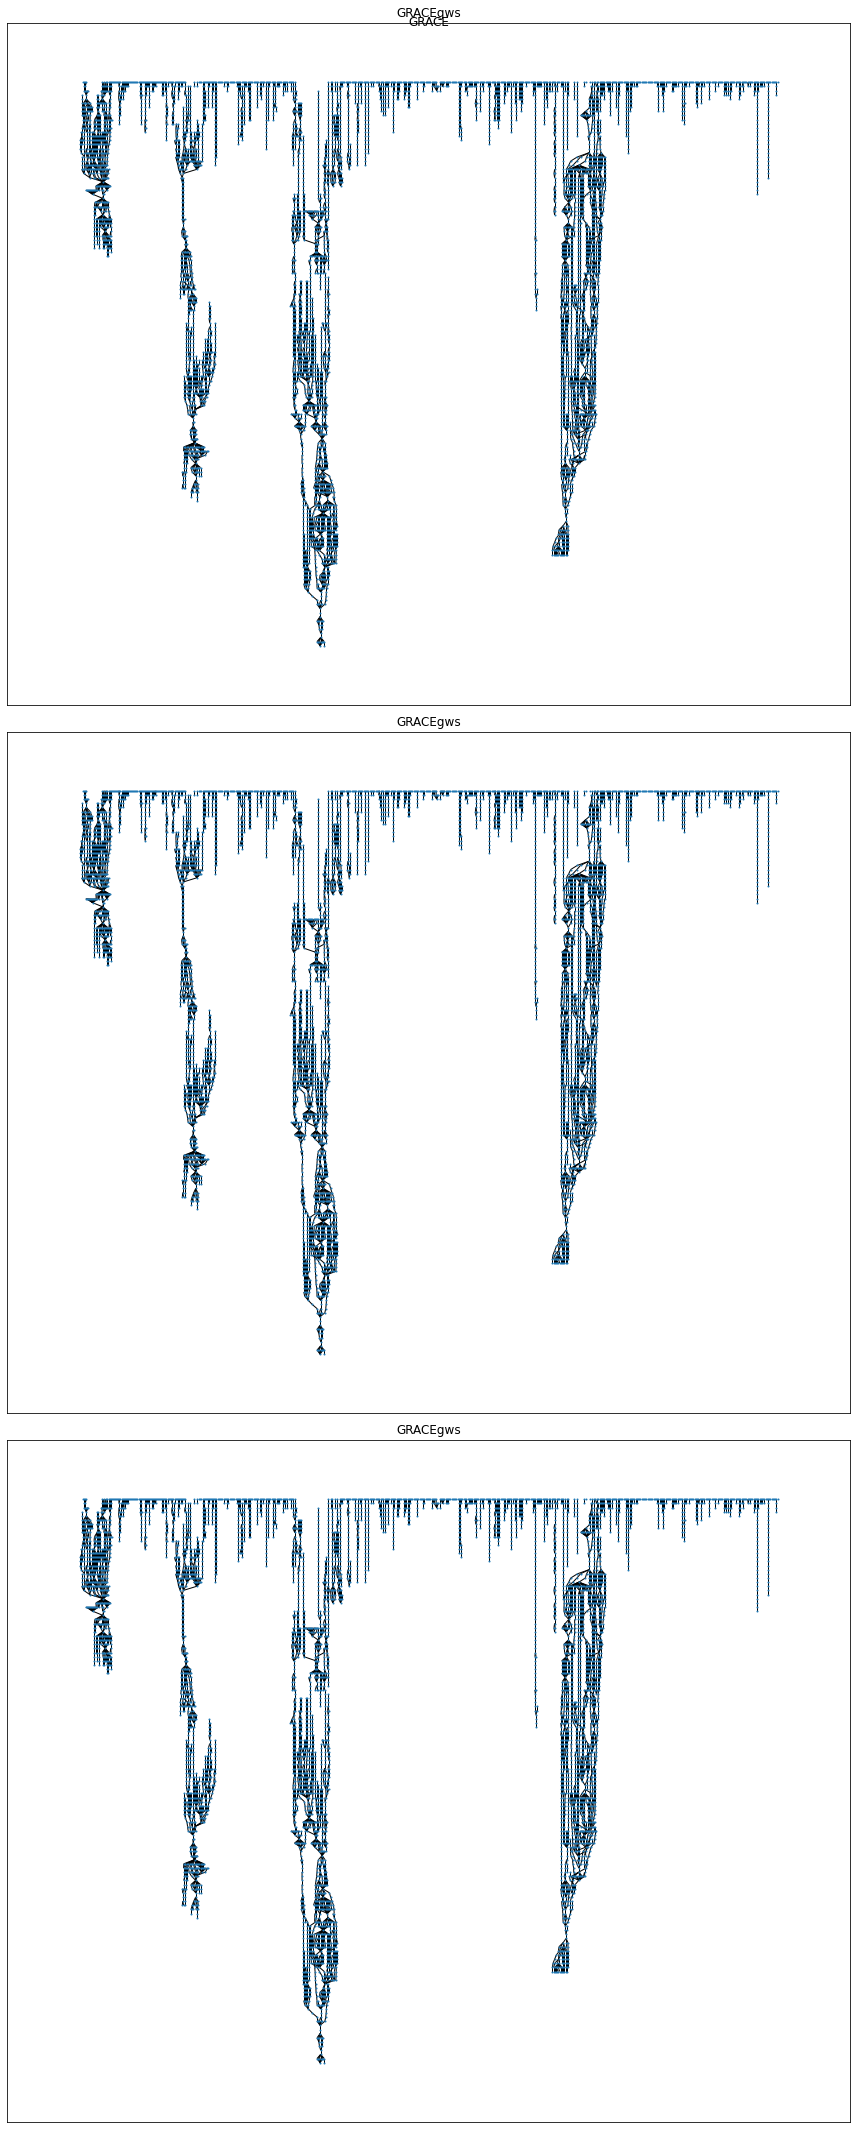

In [85]:
fig, axs = plt.subplots(3, 1, figsize=(12,30))

for ax, interval in zip(axs.ravel(), ['GRACEsfsm', 'GRACErtzsm', 'GRACEgws']):

    nx.draw_networkx(grace_topog[var], grace_pos[var], with_labels=False, node_size=1, ax=ax)
    ax.set_title(var)

fig.suptitle('GRACE')

plt.tight_layout()

In [95]:
path = f'{dm_path}/grace/WA/grace_WA_nx.pickle'

pickle_data([grace_topog, grace_pos], path)